Test different methods for continuous readout. Loop back the DAC and ADC of the KIDs chain (or connect through the simulator, that's fine).

In [7]:
import sys
# sys.path.append('../../../qick/qick_lib/')
sys.path.append('../soft/')
import Scan
from mkids import *
import matplotlib.pyplot as plt
import time

In [2]:
board = Scan.getBoard()

if board == 'zcu111':
    bitfile = 'mkids_2x2_kidsim_v1' 
elif board == 'zcu216':
    bitfile = 'mkids_2x2_kidsim_v2'
elif board == 'rfsoc4x2':
    bitfile = 'mkids_v3'
else:
    raise Exception("Do not know what to do with %s"%board)
scan = Scan.Scan(bitfile, iKids=0, iSimu=0)

print(scan.soc)


QICK configuration:

	Board: ZCU111

	Dual Chains
	Dual 0: 
		ADC: 224_0, fs = 4096.0 MHz, Decimation    = 4
		DAC: 229_0, fs = 4096.0 MHz, Interpolation = 4
		PFB: fs = 2.0 MHz, fc = 1.0 MHz, 1024 channels
	Dual 1: 
		ADC: 225_0, fs = 4096.0 MHz, Decimation    = 4
		DAC: 229_2, fs = 4096.0 MHz, Interpolation = 4
		PFB: fs = 2.0 MHz, fc = 1.0 MHz, 1024 channels

	Sim Chains
	Sim 0: 
		ADC: 224_1, fs = 4096.0 MHz, Decimation    = 4
		DAC: 229_1, fs = 4096.0 MHz, Interpolation = 4
		PFB: fs = 8.0 MHz, fc = 4.0 MHz, 256 channels
	Sim 1: 
		ADC: 225_1, fs = 4096.0 MHz, Decimation    = 4
		DAC: 229_3, fs = 4096.0 MHz, Interpolation = 4
		PFB: fs = 8.0 MHz, fc = 4.0 MHz, 256 channels


In [3]:
fMixer = 512

# Initialize simulation chain
simu = scan.simuChain
simu.analysis.qout(3)
simu.synthesis.qout(3)
simu.alloff()

# Get the kids chain
kids = scan.kidsChain

# Set the mixer of the analysis and synthesis chains to be the same

fMixerQ = kids.fq(fMixer)
_ = scan.set_mixer(fMixerQ)

In [29]:
fTone = 613.5
deltaF = 0.0001
g = 0.9
decimation = 16
qout = 2

# play+read two tones on either side of a channel boundary
# zero power on tone 1, so we are just playing tone 0 and reading at both frequencies
# on tone 1 we should now see a slowly oscillating signal
mytone = 1

f_samp = kids.analysis.dict['chain']['fs_ch']/decimation
streamer = getattr(kids.soc, kids.analysis.dict['chain']['streamer'])


kids.set_decimation(decimation)
kids.analysis.qout(qout)
kids.synthesis.qout(qout)
freqs = np.array([fTone-deltaF/2, fTone+deltaF/2])
fis = 0.123*np.arange(len(freqs))
gs = np.array([g,0.0])
gs[0] /= 2
cgs = None
print(gs)
kids.set_tones(freqs,fis,gs,cgs, verbose=True)

nt = kids.ntrans[mytone]
idx = kids.idxs[mytone]

[0.45 0.  ]
mkids.py:  in set_tones
   self.chs    = [101 102]
   self.ntrans = [12 12]
   self.idxs   = [5 6]
mkids.py set_tones:  fOffset, fiDeg, g, cg, ch, comp= 0.4999500000849366 0.0 0.45 0.0 101 False
dds.py  AxisDdsDualV1 ddscfg:  f, fi, g, ch, comp= 499950.0000849366 0.0 0.45 101 False
mkids.py set_tones:  fOffset, fiDeg, g, cg, ch, comp= -0.4999500000849366 7.047380880109126 0.0 0.0 102 False
dds.py  AxisDdsDualV1 ddscfg:  f, fi, g, ch, comp= -499950.0000849366 7.047380880109126 0.0 102 False
mkids.py:  enabledChs and chs identical


In [30]:
# using get_xs() in the high-level interface
t0 = time.time()
data = []
for i in range(5):
    data.append(kids.get_xs()[1])
    print(time.time()-t0)    

0.09387397766113281
0.18576383590698242
0.27702856063842773
0.3682270050048828
0.460127592086792


In [31]:
# using get_data_all() in the old streamer driver
t0 = time.time()
data = []
for i in range(5):
    iq = streamer.get_data_all()['samples'][nt][2*idx:2*idx+2]
    data.append(iq.T.dot([1,1j]))
    print(time.time()-t0)

0.09124159812927246
0.18381404876708984
0.27436304092407227
0.36482834815979004
0.45607709884643555


In [32]:
# using ping-pong readout in the new streamer driver
streamer.start_pingpong(10000)

t0 = time.time()
data = []
for i in range(5):
    iq = streamer.get_data_pingpong()['samples'][nt][2*idx:2*idx+2]
    data.append(iq.T.dot([1,1j]))
    print(time.time()-t0)

0.08778929710388184
0.16803455352783203
0.24802255630493164
0.328777551651001
0.40856122970581055


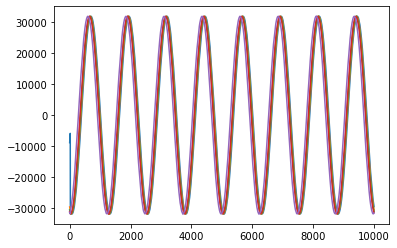

In [33]:
# plot the I values
for x in data:
    plt.plot(np.real(x))

worst gap: 447.108389 us
sample spacing is 8.000000 us, streamer FIFO depth (16 samples) is 128.000000 us


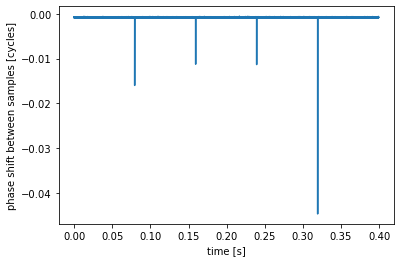

In [34]:
allx = np.concatenate(data)[100:] # the first ~20 samples are stale data

# plot the phase
# plt.plot(np.angle(allx))

phases = np.unwrap(np.angle(allx))/(2*np.pi)

# plot the phase difference between samples, and use it to estimate the gaps in the data
dphase = phases[1:]-phases[:-1]
t = np.arange(len(dphase))/(f_samp*1e6)
plt.plot(t, dphase)
plt.ylabel("phase shift between samples [cycles]");
plt.xlabel("time [s]")
print("worst gap: %f us"%(np.abs(dphase).max()/deltaF))
print("sample spacing is %f us, streamer FIFO depth (16 samples) is %f us"%(1/f_samp, 16/f_samp))